# Test Data Loading and Stimulus Mapping

This notebook tests:
1. EEG data loading from .mat files
2. Behavioral data loading (ratings)
3. Mapping between EEG trials and stimulus/rating information
4. Label creation for classification

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import our modules
from data.loader import (
    load_eeg_from_mat,
    create_mne_epochs,
    load_subject_eeg,
    load_behavioral_data,
    load_stimulus_order,
    load_subject_data,
    create_labels
)
from config import MAT_DATA_DIR, LOGS_DIR

print(f"MAT_DATA_DIR: {MAT_DATA_DIR}")
print(f"LOGS_DIR: {LOGS_DIR}")

MAT_DATA_DIR: c:\Users\yanni\Desktop\TUM MSEI\2. Semester\Lab\Recording\classification\notebooks\preprocessed_data
LOGS_DIR: c:\Users\yanni\Desktop\TUM MSEI\2. Semester\Lab\Recording\classification\notebooks\logs


## 1. Configuration

Set the paths to your data files. Adjust these paths as needed.

In [3]:
from pathlib import Path

# Path to preprocessed .mat file
# Adjust this path to match your data location
MAT_FILE = Path("../../../preprocessed_data/sub-001.mat")

# Path to behavioral logs
# Using the code_current logs for testing
LOGS_PATH = Path("../../code_current/logs")

# Participant ID (must match the behavioral data filename)
PARTICIPANT_ID = "yannick"  # This should match {participant_id}_data.csv

print(f"MAT file exists: {MAT_FILE.exists()}")
print(f"Logs path exists: {LOGS_PATH.exists()}")

MAT file exists: True
Logs path exists: True


## 2. Test EEG Data Loading

In [16]:
# Test loading raw EEG data from .mat file
if MAT_FILE.exists():
    print("Loading EEG data from .mat file...")
    eeg_data = load_eeg_from_mat(MAT_FILE)
    
    print(f"\n--- EEG Data Summary ---")
    print(f"Data shape: {eeg_data['data'].shape}")
    print(f"  - Trials: {eeg_data['n_trials']}")
    print(f"  - Channels: {eeg_data['n_channels']}")
    print(f"  - Samples: {eeg_data['n_samples']}")
    print(f"Sampling frequency: {eeg_data['sfreq']} Hz")
    print(f"Epoch start time (tmin): {eeg_data['tmin']} s")
    print(f"\nChannel names ({len(eeg_data['ch_names'])}):")
    print(eeg_data['ch_names'])
else:
    print(f"MAT file not found at: {MAT_FILE.absolute()}")
    print("Please update the MAT_FILE path above.")

Loading EEG data from .mat file...

--- EEG Data Summary ---
Data shape: (60, 30, 17500)
  - Trials: 60
  - Channels: 30
  - Samples: 17500
Sampling frequency: 500 Hz
Epoch start time (tmin): -3 s

Channel names (30):
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']


## 3. Test MNE Epochs Creation

In [5]:
if MAT_FILE.exists():
    print("Creating MNE epochs with baseline correction and cropping...")
    
    # Create epochs with default settings (baseline correction + cropping)
    epochs = create_mne_epochs(eeg_data, apply_baseline=True, crop_epochs=True)
    
    print(f"\n--- Processed Epochs ---")
    print(f"Number of epochs: {len(epochs)}")
    print(f"Time range: {epochs.tmin:.2f}s to {epochs.tmax:.2f}s")
    print(f"Data shape: {epochs.get_data().shape}")
    
    # Calculate duration
    duration = epochs.tmax - epochs.tmin
    print(f"Epoch duration: {duration:.2f}s")
    print(f"Samples per epoch: {epochs.get_data().shape[2]}")

Creating MNE epochs with baseline correction and cropping...


c:\Users\yanni\Desktop\TUM MSEI\2. Semester\Lab\Recording\classification\notebooks\..\data\loader.py:210: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsArray'>.tmax (31.998 s)
  epochs = epochs.crop(tmin=crop_tmin, tmax=crop_tmax)



--- Processed Epochs ---
Number of epochs: 60
Time range: 0.10s to 32.00s
Data shape: (60, 30, 15950)
Epoch duration: 31.90s
Samples per epoch: 15950


Plotting average ERP across all trials...


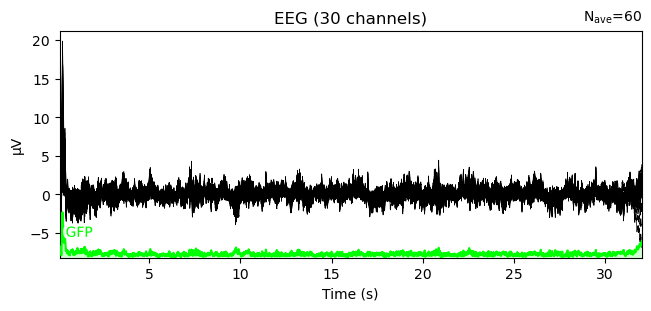

<Figure size 640x480 with 0 Axes>

In [6]:
# Visualize the average ERP
if MAT_FILE.exists():
    print("Plotting average ERP across all trials...")
    fig = epochs.average().plot(gfp=True, show=True)
    plt.tight_layout()

## 4. Test Behavioral Data Loading

In [7]:
# Load behavioral data
try:
    behavioral_df = load_behavioral_data(PARTICIPANT_ID, LOGS_PATH)
    print(f"\n--- Behavioral Data ---")
    print(f"Shape: {behavioral_df.shape}")
    print(f"Columns: {list(behavioral_df.columns)}")
    print(f"\nFirst 10 trials:")
    display(behavioral_df.head(10))
except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"\nAvailable files in {LOGS_PATH}:")
    if LOGS_PATH.exists():
        for f in LOGS_PATH.glob("*_data.csv"):
            print(f"  - {f.stem.replace('_data', '')}")


--- Behavioral Data ---
Shape: (60, 6)
Columns: ['participant_id', 'trial_num', 'stimulus_name', 'origin_pool', 'familiarity_rating', 'liking_rating']

First 10 trials:


,participant_id,trial_num,stimulus_name,origin_pool,familiarity_rating,liking_rating
0,yannick,1,J.I.D - 151 Rum (Lyrics).wav,unfamiliar_pool,0,1
1,yannick,2,The Midnight - Days of Thunder (lyrics).wav,unfamiliar_pool,1,5
2,yannick,3,KennyHoopla - ESTELLA Ft Travis Barker (Lyrics...,unfamiliar_pool,1,5
3,yannick,4,Valley - like 1999 (lyrics).wav,unfamiliar_pool,4,2
4,yannick,5,Colorado - KOTA The Friend (Lyrics).wav,unfamiliar_pool,4,4
5,yannick,6,Saint Motel - ＂Move＂ Lyrics ｜ Official FIFA17 ...,unfamiliar_pool,5,4
6,yannick,7,Ed Sheeran - Shape of You (Lyrics).wav,familiar_pool,5,1
7,yannick,8,"Ariana Grande - thank u, next (Official Lyric ...",familiar_pool,5,1
8,yannick,9,Lewis Capaldi - Someone You Loved (Lyrics).wav,familiar_pool,5,4
9,yannick,10,DREAMERS - Sweet Disaster (Official Lyric Vide...,unfamiliar_pool,1,4


In [8]:
# Load stimulus order
try:
    stimulus_order_df = load_stimulus_order(PARTICIPANT_ID, LOGS_PATH)
    print(f"\n--- Stimulus Order ---")
    print(f"Shape: {stimulus_order_df.shape}")
    print(f"Columns: {list(stimulus_order_df.columns)}")
    print(f"\nFirst 10 stimuli:")
    display(stimulus_order_df.head(10))
except FileNotFoundError as e:
    print(f"Error: {e}")


--- Stimulus Order ---
Shape: (60, 2)
Columns: ['stimulus_path', 'origin_pool']

First 10 stimuli:


,stimulus_path,origin_pool
0,/home/robotbci/Documents/Alireza Malekmohammad...,unfamiliar_pool
1,/home/robotbci/Documents/Alireza Malekmohammad...,unfamiliar_pool
2,/home/robotbci/Documents/Alireza Malekmohammad...,unfamiliar_pool
3,/home/robotbci/Documents/Alireza Malekmohammad...,unfamiliar_pool
4,/home/robotbci/Documents/Alireza Malekmohammad...,unfamiliar_pool
5,/home/robotbci/Documents/Alireza Malekmohammad...,unfamiliar_pool
6,/home/robotbci/Documents/Alireza Malekmohammad...,familiar_pool
7,/home/robotbci/Documents/Alireza Malekmohammad...,familiar_pool
8,/home/robotbci/Documents/Alireza Malekmohammad...,familiar_pool
9,/home/robotbci/Documents/Alireza Malekmohammad...,unfamiliar_pool


## 5. Analyze Rating Distributions

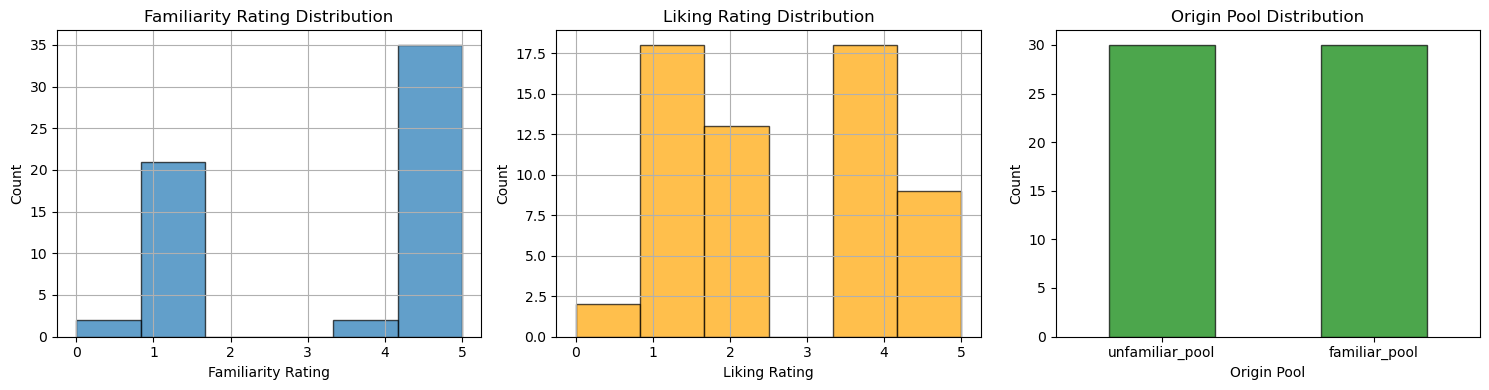


--- Rating Statistics ---

Familiarity ratings:
count    60.000000
mean      3.400000
std       1.993209
min       0.000000
25%       1.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: familiarity_rating, dtype: float64

Liking ratings:
count    60.000000
mean      2.683333
std       1.599700
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       5.000000
Name: liking_rating, dtype: float64

Origin pool counts:
origin_pool
unfamiliar_pool    30
familiar_pool      30
Name: count, dtype: int64


In [9]:
if 'behavioral_df' in dir():
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Familiarity ratings distribution
    ax = axes[0]
    behavioral_df['familiarity_rating'].hist(bins=6, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Familiarity Rating')
    ax.set_ylabel('Count')
    ax.set_title('Familiarity Rating Distribution')
    ax.set_xticks(range(6))
    
    # Liking ratings distribution
    ax = axes[1]
    behavioral_df['liking_rating'].hist(bins=6, ax=ax, edgecolor='black', alpha=0.7, color='orange')
    ax.set_xlabel('Liking Rating')
    ax.set_ylabel('Count')
    ax.set_title('Liking Rating Distribution')
    ax.set_xticks(range(6))
    
    # Origin pool distribution
    ax = axes[2]
    behavioral_df['origin_pool'].value_counts().plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7, color='green')
    ax.set_xlabel('Origin Pool')
    ax.set_ylabel('Count')
    ax.set_title('Origin Pool Distribution')
    ax.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n--- Rating Statistics ---")
    print(f"\nFamiliarity ratings:")
    print(behavioral_df['familiarity_rating'].describe())
    print(f"\nLiking ratings:")
    print(behavioral_df['liking_rating'].describe())
    print(f"\nOrigin pool counts:")
    print(behavioral_df['origin_pool'].value_counts())

## 6. Test Label Creation

In [10]:
if 'behavioral_df' in dir():
    print("--- Testing Label Creation ---\n")
    
    # Test different label types
    label_types = [
        ("familiarity_binary", 3),
        ("liking_binary", 3),
        ("origin_pool", None),
        ("familiarity_multiclass", None)
    ]
    
    for target_type, threshold in label_types:
        if threshold:
            labels = create_labels(behavioral_df, target_type=target_type, threshold=threshold)
        else:
            labels = create_labels(behavioral_df, target_type=target_type)
        
        unique, counts = np.unique(labels, return_counts=True)
        
        print(f"{target_type}:")
        print(f"  Labels: {unique}")
        print(f"  Counts: {counts}")
        print(f"  Class balance: {counts / counts.sum() * 100}%")
        print()

--- Testing Label Creation ---

familiarity_binary:
  Labels: [0 1]
  Counts: [23 37]
  Class balance: [38.33333333 61.66666667]%

liking_binary:
  Labels: [0 1]
  Counts: [33 27]
  Class balance: [55. 45.]%

origin_pool:
  Labels: [0]
  Counts: [60]
  Class balance: [100.]%

familiarity_multiclass:
  Labels: [-1  0  3  4]
  Counts: [ 2 21  2 35]
  Class balance: [ 3.33333333 35.          3.33333333 58.33333333]%



## 7. Familiarity vs Liking Relationship

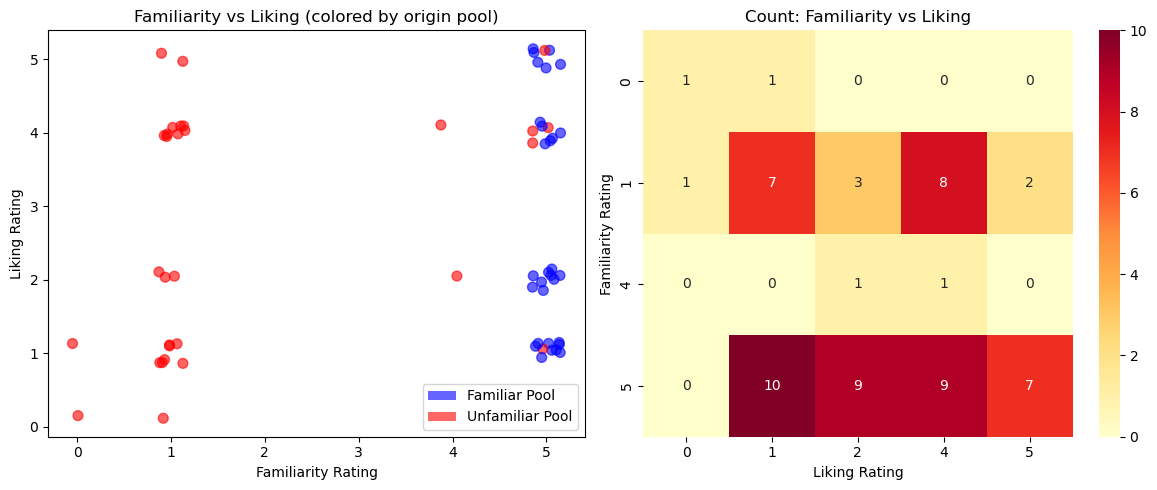


Correlation between Familiarity and Liking: 0.141


In [10]:
if 'behavioral_df' in dir():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot: Familiarity vs Liking
    ax = axes[0]
    # Add jitter for better visualization
    jitter = 0.15
    x = behavioral_df['familiarity_rating'] + np.random.uniform(-jitter, jitter, len(behavioral_df))
    y = behavioral_df['liking_rating'] + np.random.uniform(-jitter, jitter, len(behavioral_df))
    colors = behavioral_df['origin_pool'].map({'familiar_pool': 'blue', 'unfamiliar_pool': 'red'})
    
    ax.scatter(x, y, c=colors, alpha=0.6, s=50)
    ax.set_xlabel('Familiarity Rating')
    ax.set_ylabel('Liking Rating')
    ax.set_title('Familiarity vs Liking (colored by origin pool)')
    ax.set_xticks(range(6))
    ax.set_yticks(range(6))
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.6, label='Familiar Pool'),
        Patch(facecolor='red', alpha=0.6, label='Unfamiliar Pool')
    ]
    ax.legend(handles=legend_elements)
    
    # Heatmap: Familiarity vs Liking counts
    ax = axes[1]
    pivot = pd.crosstab(behavioral_df['familiarity_rating'], behavioral_df['liking_rating'])
    sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
    ax.set_xlabel('Liking Rating')
    ax.set_ylabel('Familiarity Rating')
    ax.set_title('Count: Familiarity vs Liking')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation
    corr = behavioral_df['familiarity_rating'].corr(behavioral_df['liking_rating'])
    print(f"\nCorrelation between Familiarity and Liking: {corr:.3f}")

## 8. Verify Trial Mapping (EEG ↔ Behavioral)

In [11]:
if MAT_FILE.exists() and 'behavioral_df' in dir():
    print("--- Trial Mapping Verification ---\n")
    
    n_eeg_trials = eeg_data['n_trials']
    n_behavioral_trials = len(behavioral_df)
    
    print(f"EEG trials: {n_eeg_trials}")
    print(f"Behavioral trials: {n_behavioral_trials}")
    
    if n_eeg_trials == n_behavioral_trials:
        print("\n[OK] Trial counts match!")
        print("\nTrial mapping (first 10):")
        for i in range(min(10, n_eeg_trials)):
            row = behavioral_df.iloc[i]
            print(f"  Trial {i+1}: {row['stimulus_name'][:50]}... | "
                  f"Fam={row['familiarity_rating']}, Like={row['liking_rating']}, Pool={row['origin_pool']}")
    else:
        print(f"\n[WARNING] Trial count mismatch!")
        print(f"  Difference: {abs(n_eeg_trials - n_behavioral_trials)} trials")

--- Trial Mapping Verification ---

EEG trials: 60
Behavioral trials: 60

[OK] Trial counts match!

Trial mapping (first 10):
  Trial 1: J.I.D - 151 Rum (Lyrics).wav... | Fam=0, Like=1, Pool=unfamiliar_pool
  Trial 2: The Midnight - Days of Thunder (lyrics).wav... | Fam=1, Like=5, Pool=unfamiliar_pool
  Trial 3: KennyHoopla - ESTELLA Ft Travis Barker (Lyrics).wa... | Fam=1, Like=5, Pool=unfamiliar_pool
  Trial 4: Valley - like 1999 (lyrics).wav... | Fam=4, Like=2, Pool=unfamiliar_pool
  Trial 5: Colorado - KOTA The Friend (Lyrics).wav... | Fam=4, Like=4, Pool=unfamiliar_pool
  Trial 6: Saint Motel - ＂Move＂ Lyrics ｜ Official FIFA17 Soun... | Fam=5, Like=4, Pool=unfamiliar_pool
  Trial 7: Ed Sheeran - Shape of You (Lyrics).wav... | Fam=5, Like=1, Pool=familiar_pool
  Trial 8: Ariana Grande - thank u, next (Official Lyric Vide... | Fam=5, Like=1, Pool=familiar_pool
  Trial 9: Lewis Capaldi - Someone You Loved (Lyrics).wav... | Fam=5, Like=4, Pool=familiar_pool
  Trial 10: DREAMERS - Sweet

## 9. Test Full Subject Loading (Combined)

In [15]:
if MAT_FILE.exists():
    print("Testing load_subject_data() - combined loading function...\n")
    
    # Define bad trials to exclude (0-indexed)
    # Set to None or empty list to include all trials
    BAD_TRIALS = []  # e.g., [5, 12, 47]
    
    try:
        subject_data = load_subject_data(
            participant_id=PARTICIPANT_ID,
            mat_filepath=MAT_FILE,
            logs_dir=LOGS_PATH,
            apply_baseline=True,
            crop_epochs=True,
            return_mne_epochs=True,
            exclude_trials=BAD_TRIALS if BAD_TRIALS else None
        )
        
        print("--- Subject Data Summary ---")
        print(f"Participant: {subject_data['participant_id']}")
        print(f"\nEEG Data:")
        print(f"  Shape: {subject_data['eeg_data'].shape}")
        print(f"  Channels: {len(subject_data['ch_names'])}")
        print(f"  Sampling rate: {subject_data['sfreq']} Hz")
        print(f"\nTrial Info:")
        print(f"  Original trials: {subject_data['metadata']['n_trials_original']}")
        print(f"  Excluded trials: {subject_data['metadata']['n_trials_excluded']}")
        print(f"  Remaining trials: {subject_data['metadata']['n_trials']}")
        if subject_data.get('excluded_trials'):
            print(f"  Excluded indices: {subject_data['excluded_trials']}")
        print(f"\nBehavioral data shape: {subject_data['behavioral'].shape}")
        print(f"MNE Epochs available: {'epochs' in subject_data}")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

Testing load_subject_data() - combined loading function...



c:\Users\yanni\Desktop\TUM MSEI\2. Semester\Lab\Recording\classification\notebooks\..\data\loader.py:210: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsArray'>.tmax (31.998 s)
  epochs = epochs.crop(tmin=crop_tmin, tmax=crop_tmax)


--- Subject Data Summary ---
Participant: yannick

EEG Data:
  Shape: (60, 30, 15950)
  Channels: 30
  Sampling rate: 500 Hz

Trial Info:
  Original trials: 60
  Excluded trials: 0
  Remaining trials: 60

Behavioral data shape: (60, 6)
MNE Epochs available: True


## 10. Summary Statistics per Condition

In [12]:
if 'behavioral_df' in dir():
    print("--- Summary by Origin Pool ---\n")
    
    summary = behavioral_df.groupby('origin_pool').agg({
        'familiarity_rating': ['mean', 'std', 'min', 'max'],
        'liking_rating': ['mean', 'std', 'min', 'max'],
        'trial_num': 'count'
    }).round(2)
    
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.rename(columns={'trial_num_count': 'n_trials'})
    
    display(summary)
    
    # Statistical test
    from scipy import stats
    
    familiar = behavioral_df[behavioral_df['origin_pool'] == 'familiar_pool']
    unfamiliar = behavioral_df[behavioral_df['origin_pool'] == 'unfamiliar_pool']
    
    print("\n--- Statistical Tests (Familiar vs Unfamiliar Pool) ---")
    
    # Familiarity rating comparison
    t_fam, p_fam = stats.ttest_ind(familiar['familiarity_rating'], unfamiliar['familiarity_rating'])
    print(f"\nFamiliarity Rating: t={t_fam:.3f}, p={p_fam:.4f}")
    
    # Liking rating comparison  
    t_lik, p_lik = stats.ttest_ind(familiar['liking_rating'], unfamiliar['liking_rating'])
    print(f"Liking Rating: t={t_lik:.3f}, p={p_lik:.4f}")

--- Summary by Origin Pool ---



,familiarity_rating_mean,familiarity_rating_std,familiarity_rating_min,familiarity_rating_max,liking_rating_mean,liking_rating_std,liking_rating_min,liking_rating_max,n_trials
origin_pool,,,,,,,,,
familiar_pool,5.0,0.00,5,5,2.70,1.58,1,5,30
unfamiliar_pool,1.8,1.67,0,5,2.67,1.65,0,5,30



--- Statistical Tests (Familiar vs Unfamiliar Pool) ---

Familiarity Rating: t=10.500, p=0.0000
Liking Rating: t=0.080, p=0.9365


c:\Users\yanni\anaconda3\envs\eeg_classification\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


## 11. Quick Sanity Check: EEG Signal Quality

--- EEG Signal Statistics ---

Data shape: (60, 30, 15950)
Data dtype: float64

Amplitude statistics (in Volts):
  Min: -1.37e-04
  Max: 2.03e-04
  Mean: 9.64e-08
  Std: 5.84e-06

[OK] No flat channels detected


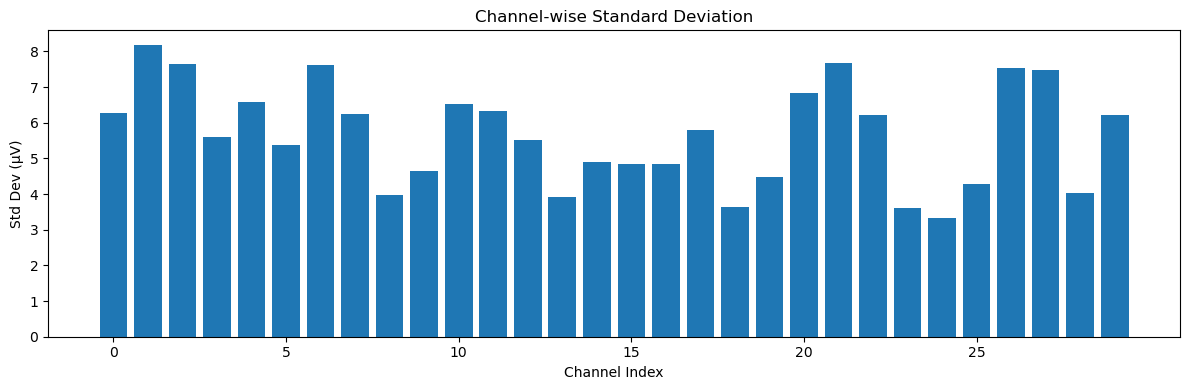

In [14]:
if MAT_FILE.exists() and 'subject_data' in dir():
    eeg = subject_data['eeg_data']
    
    print("--- EEG Signal Statistics ---\n")
    print(f"Data shape: {eeg.shape}")
    print(f"Data dtype: {eeg.dtype}")
    print(f"\nAmplitude statistics (in Volts):")
    print(f"  Min: {eeg.min():.2e}")
    print(f"  Max: {eeg.max():.2e}")
    print(f"  Mean: {eeg.mean():.2e}")
    print(f"  Std: {eeg.std():.2e}")
    
    # Check for flat channels
    channel_stds = eeg.std(axis=(0, 2))  # Std across trials and time for each channel
    flat_threshold = 1e-10
    flat_channels = np.where(channel_stds < flat_threshold)[0]
    
    if len(flat_channels) > 0:
        print(f"\n[WARNING] Potentially flat channels: {flat_channels}")
    else:
        print(f"\n[OK] No flat channels detected")
    
    # Plot channel variance
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(range(len(channel_stds)), channel_stds * 1e6)  # Convert to µV
    ax.set_xlabel('Channel Index')
    ax.set_ylabel('Std Dev (µV)')
    ax.set_title('Channel-wise Standard Deviation')
    ax.set_xticks(range(0, len(channel_stds), 5))
    plt.tight_layout()
    plt.show()